# ResNet_code

ps：

pip install d2l

pip install matplotlib==3.0.0

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from d2l import torch as d2l
import matplotlib.pyplot as plt

In [2]:
# 1. 加载数据集
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [3]:
# 2. net
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels,
                use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                              kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                              kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                              kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

def resnet_block(input_channels, num_channels, 
                 num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i==0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                               use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True)) 
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

In [4]:
# 3. 初始化weight

def init_weights(m):
  if type(m) in [nn.Linear, nn.Conv2d]:
    nn.init.xavier_uniform_(m.weight)
net.apply(init_weights)

# 4. 定义loss

l = nn.CrossEntropyLoss()

# 5. 定义优化器

o = torch.optim.SGD(net.parameters(), lr=0.05)

In [5]:
def acc(X,y,net):
  p_predict = net(X)
  y_predict = torch.argmax(p_predict,axis=1)
  output = y_predict - y
  right_pre = len(output[output==0])
  right_accu = right_pre/len(output)
  return right_accu

def eval_accu(net=None, dataset=None, cuda=False):
  accu = 0
  batch = 0
  net.eval()

  for X,y in dataset:
    if cuda:
      net.cuda()
      X,y = X.cuda(),y.cuda()
    accu += acc(X, y, net)
    batch += 1
  avg_acc = accu/batch
  return avg_acc

def train_net(net=None, epochs=10, loss = None, optimizer=None, 
              train_iter=None, test_iter=None, cuda=False):
  train_accu_history = []
  test_accu_history = []
  train_loss = []

  for epoch in range(epochs):

    net.train()
    for X,y in train_iter:
      if cuda:
        net.cuda()
        X,y = X.cuda(),y.cuda()
      l = loss(net(X), y)
      optimizer.zero_grad()
      l.backward()
      optimizer.step()

    net.eval() 
    l = loss(net(X), y)
    train_loss.append(l.cpu().detach())
    

    train_avg_acc = eval_accu(net, train_iter, cuda)
    test_avg_acc = eval_accu(net, test_iter, cuda)
    train_accu_history.append(train_avg_acc)
    test_accu_history.append(test_avg_acc)

    print(f'epoch {epoch + 1}, loss {l:f}, train_accu {train_avg_acc:f}, test_accu {test_avg_acc:f}')
  
  x_label_value = [str(i) for i in range(1,epochs+1)]
  plt.plot(x_label_value, train_accu_history, label='train_accu', color='g', linestyle='dashed')
  plt.plot(x_label_value, test_accu_history, label='test_accu', color='r', linestyle='dashed')
  plt.plot(x_label_value, train_loss, label='train_loss', color='b')
  plt.xlabel('epoch')
  plt.ylim(0.1,2)
  plt.legend()
  plt.show()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1, loss 0.202452, train_accu 0.839816, test_accu 0.839982
epoch 2, loss 0.103097, train_accu 0.881261, test_accu 0.881233
epoch 3, loss 0.058206, train_accu 0.911004, test_accu 0.911004
epoch 4, loss 0.141420, train_accu 0.892121, test_accu 0.892343
epoch 5, loss 0.115330, train_accu 0.909984, test_accu 0.909846
epoch 6, loss 0.010613, train_accu 0.968141, test_accu 0.968085
epoch 7, loss 0.122145, train_accu 0.925837, test_accu 0.925781
epoch 8, loss 0.024290, train_accu 0.965824, test_accu 0.965880
epoch 9, loss 0.002056, train_accu 0.989716, test_accu 0.989716
epoch 10, loss 0.116301, train_accu 0.985029, test_accu 0.985001


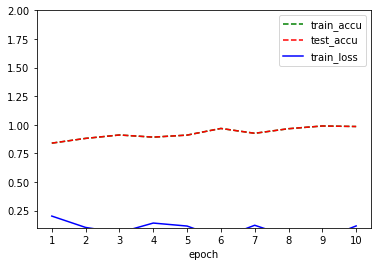

CPU times: user 8min 48s, sys: 22.3 s, total: 9min 10s
Wall time: 11min 41s


In [6]:
%%time
train_net(net=net, epochs=10, loss = l, optimizer=o, 
          train_iter=train_iter, test_iter=train_iter, cuda=True)